Let's cluster the samples in the SwissProt GO dataset by their GO terms so we can use the cluster assignment to later do a stratified train/test split. We'll start by creating some embeddings for the terms.

/home/andrew/Workspace/AmiGO/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embedding dimensionality: 512, Explained Variance: 0.8009


Initialization 0
  Iteration 10	 time lapse 49.95648s	 ll change 0.80041
  Iteration 20	 time lapse 58.52499s	 ll change 0.19399
  Iteration 30	 time lapse 30.58502s	 ll change 0.22938
  Iteration 40	 time lapse 38.22092s	 ll change 0.09993
  Iteration 50	 time lapse 36.66507s	 ll change 0.68168
  Iteration 60	 time lapse 44.43379s	 ll change 0.06218
  Iteration 70	 time lapse 55.66920s	 ll change 0.04393
  Iteration 80	 time lapse 25.86366s	 ll change 0.04976
  Iteration 90	 time lapse 34.83131s	 ll change 0.10416
  Iteration 100	 time lapse 49.56402s	 ll change 0.01986
  Iteration 110	 time lapse 32.84009s	 ll change 0.01342
  Iteration 120	 time lapse 37.64594s	 ll change 0.03758
  Iteration 130	 time lapse 25.61130s	 ll change 0.00876
  Iteration 140	 time lapse 41.42888s	 ll change 0.00882
  Iteration 150	 time lapse 36.43480s	 ll change 0.00564
  Iteration 160	 time lapse 45.51095s	 ll change 0.00614
  Iteration 170	 tim

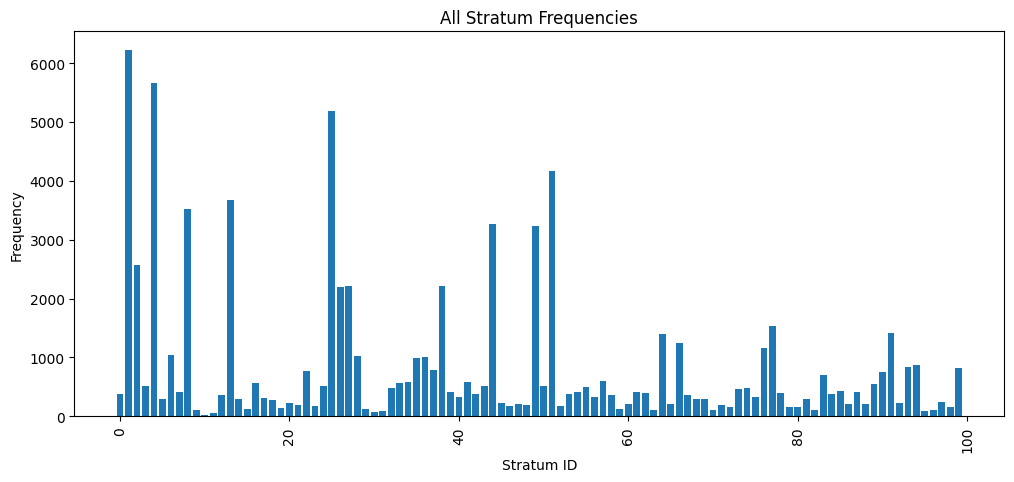



Embedding dimensionality: 256, Explained Variance: 0.8450


Initialization 0
  Iteration 10	 time lapse 10.83309s	 ll change 4.49432
  Iteration 20	 time lapse 23.33639s	 ll change 0.12143
  Iteration 30	 time lapse 18.78347s	 ll change 0.06428
  Iteration 40	 time lapse 32.36501s	 ll change 0.28636
  Iteration 50	 time lapse 21.30829s	 ll change 0.00221
  Iteration 60	 time lapse 25.85779s	 ll change 0.00092
Initialization converged. time lapse 132.48428s	 lower bound 490.62395.


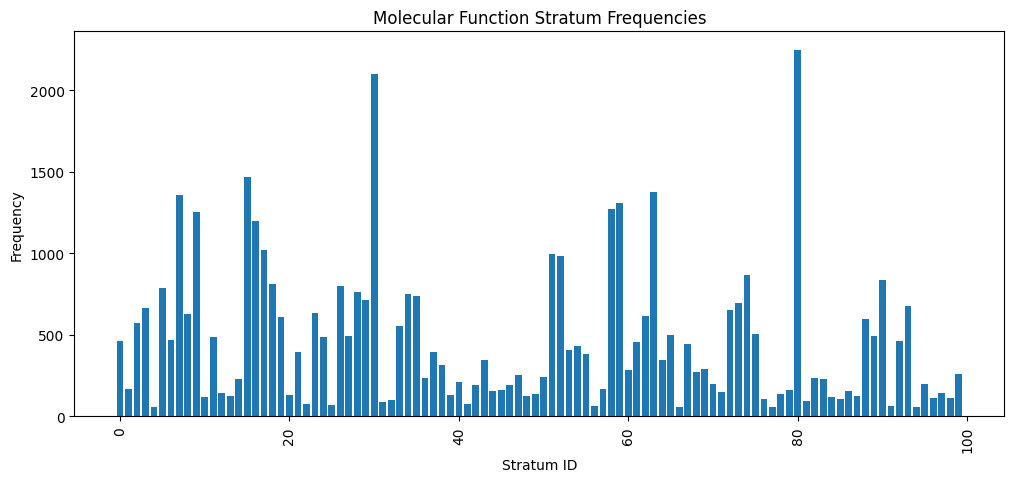



Embedding dimensionality: 512, Explained Variance: 0.8249


Initialization 0
  Iteration 10	 time lapse 27.46622s	 ll change 1.06396
  Iteration 20	 time lapse 31.87961s	 ll change 0.25700
  Iteration 30	 time lapse 27.34891s	 ll change 0.12884
  Iteration 40	 time lapse 14.33158s	 ll change 0.73066
  Iteration 50	 time lapse 38.57693s	 ll change 0.05153
  Iteration 60	 time lapse 33.03972s	 ll change 0.01654
  Iteration 70	 time lapse 20.05128s	 ll change 0.01606
  Iteration 80	 time lapse 21.60058s	 ll change 0.00629
  Iteration 90	 time lapse 30.72944s	 ll change 0.01461
  Iteration 100	 time lapse 33.73596s	 ll change 0.00643
  Iteration 110	 time lapse 29.70774s	 ll change 0.00367
  Iteration 120	 time lapse 30.14362s	 ll change 0.00549
  Iteration 130	 time lapse 17.62752s	 ll change 0.01319
  Iteration 140	 time lapse 24.34951s	 ll change 0.00387
  Iteration 150	 time lapse 26.91564s	 ll change 0.00446
  Iteration 160	 time lapse 38.79697s	 ll change 0.01031
  Iteration 170	 t

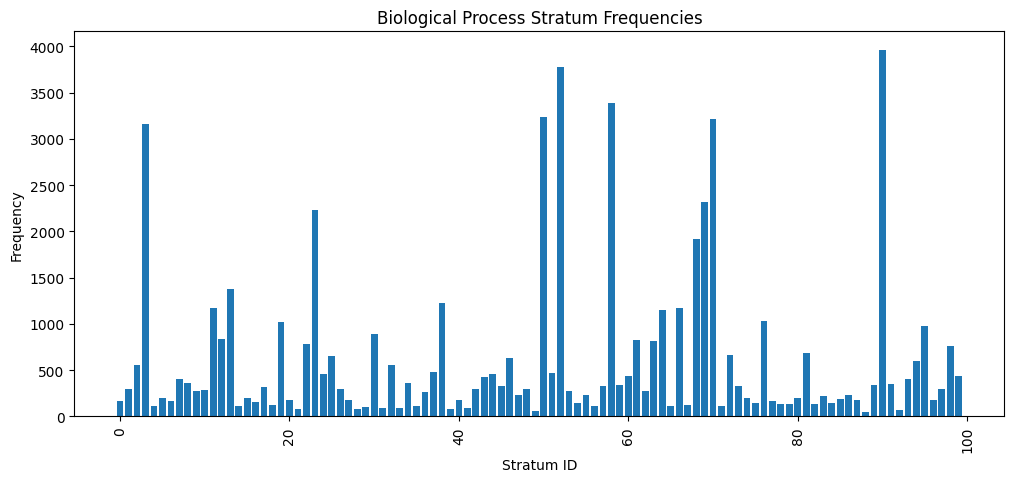



Embedding dimensionality: 128, Explained Variance: 0.8888


Initialization 0
  Iteration 10	 time lapse 3.25460s	 ll change 3.30824
  Iteration 20	 time lapse 2.65947s	 ll change 0.02573
  Iteration 30	 time lapse 2.74185s	 ll change 0.01557
  Iteration 40	 time lapse 2.64539s	 ll change 0.01295
  Iteration 50	 time lapse 2.66078s	 ll change 0.01332
Initialization converged. time lapse 15.82420s	 lower bound 314.13496.


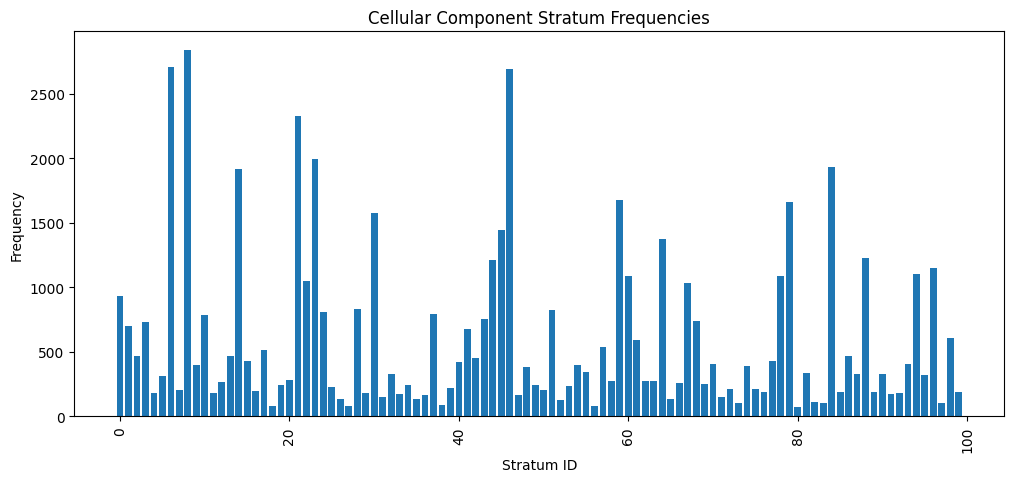

In [1]:
from functools import partial

from datasets import load_dataset

import numpy as np

from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture

from collections import Counter

import matplotlib.pyplot as plt

all_dataset_path = "./dataset/all-expanded.jsonl"
mf_dataset_path = "./dataset/mf-expanded.jsonl"
bp_dataset_path = "./dataset/bp-expanded.jsonl"
cc_dataset_path = "./dataset/cc-expanded.jsonl"

all_dimensions = 512
mf_dimensions = 256
bp_dimensions = 512
cc_dimensions = 128

num_strata = 100

random_seed = 42

new_svd = partial(TruncatedSVD, random_state=random_seed)

new_gmm = partial(
    GaussianMixture,
    n_components=num_strata,
    covariance_type="diag",
    random_state=random_seed,
    max_iter=300,
    verbose=2,
)

all_stratum_ids = {}
mf_stratum_ids = {}
bp_stratum_ids = {}
cc_stratum_ids = {}

all_counter = Counter()
mf_counter = Counter()
bp_counter = Counter()
cc_counter = Counter()

for name, dataset_path, stratum_ids, dimensions, counter in [
    ("All", all_dataset_path, all_stratum_ids, all_dimensions, all_counter),
    ("Molecular Function", mf_dataset_path, mf_stratum_ids, mf_dimensions, mf_counter),
    ("Biological Process", bp_dataset_path, bp_stratum_ids, bp_dimensions, bp_counter),
    ("Cellular Component", cc_dataset_path, cc_stratum_ids, cc_dimensions, cc_counter),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    unique_terms = set()

    for record in dataset:
        for term in record["go_terms"]:
            unique_terms.add(term)

    term_index_mapping = {term: index for index, term in enumerate(unique_terms)}

    term_embeddings = {}

    for record in dataset:
        id = record["id"]

        embedding = np.zeros(len(term_index_mapping), dtype=np.int8)

        for term in record["go_terms"]:
            if term in term_index_mapping:
                index = term_index_mapping[term]

                embedding[index] = 1

        term_embeddings[id] = embedding

    svd = new_svd(n_components=dimensions)

    x = np.stack(list(term_embeddings.values()))
    
    svd.fit(x)
    
    explained_variance = np.sum(svd.explained_variance_ratio_)

    print(f"Embedding dimensionality: {dimensions}, Explained Variance: {explained_variance:.4f}")

    z = svd.transform(x)

    for sequence_id, embedding in zip(term_embeddings.keys(), z):
        term_embeddings[sequence_id] = embedding

    print("\n")

    gmm = new_gmm()

    x = np.stack(list(term_embeddings.values()))

    predictions = gmm.fit_predict(x)

    for sequence_id, stratum_id in zip(term_embeddings.keys(), predictions):
        stratum_ids[sequence_id] = stratum_id

        counter[stratum_id] += 1

    plt.figure(figsize=(12, 5)) 

    plt.bar(counter.keys(), counter.values())

    plt.title(f"{name} Stratum Frequencies")
    plt.xticks(rotation=90)
    plt.xlabel("Stratum ID")
    plt.ylabel("Frequency")

    plt.show()

    print("\n")

Lastly, add the stratum IDs to the dataset, dropping any singletons, and write to disk.

In [2]:
import json

all_stratified_path = "./dataset/all-stratified.jsonl"
mf_stratified_path = "./dataset/mf-stratified.jsonl"
bp_stratified_path = "./dataset/bp-stratified.jsonl"
cc_stratified_path = "./dataset/cc-stratified.jsonl"

for dataset_path, stratified_path, stratum_ids, counter in [
    (all_dataset_path, all_stratified_path, all_stratum_ids, all_counter),
    (mf_dataset_path, mf_stratified_path, mf_stratum_ids, mf_counter),
    (bp_dataset_path, bp_stratified_path, bp_stratum_ids, bp_counter),
    (cc_dataset_path, cc_stratified_path, cc_stratum_ids, cc_counter),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    dropped = 0

    with open(stratified_path, "w") as file:
        for record in dataset:
            id = record["id"]
            stratum_id = stratum_ids[id]

            if counter[stratum_id] < 2:
                dropped += 1

                continue

            record["stratum_id"] = str(stratum_id)

            file.write(json.dumps(record) + "\n")

    print(f"Dropped {dropped:,} noise samples from dataset.")

    print(f"Dataset saved to {stratified_path}")

print("Done!")

Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/all-stratified.jsonl
Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/mf-stratified.jsonl
Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/bp-stratified.jsonl
Dropped 0 noise samples from dataset.
Dataset saved to ./dataset/cc-stratified.jsonl
Done!
